In [22]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [23]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNEL = 3
EPOCHS=50

In [24]:
tf_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle='True',
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [25]:
class_names = tf_dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

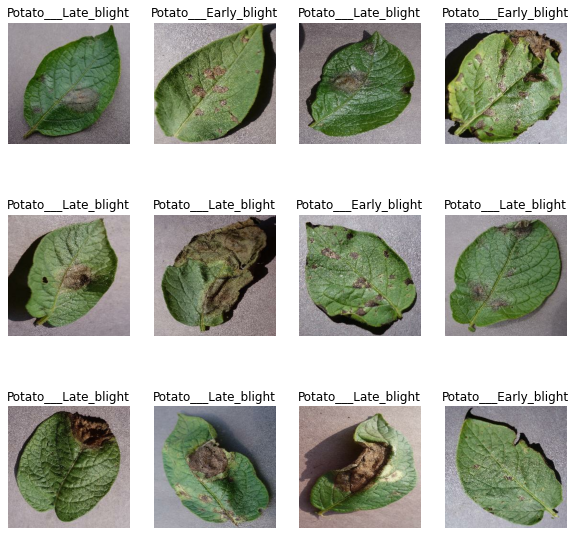

In [26]:
plt.figure(figsize=(10,10))
for batch_image, batch_label in tf_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(batch_image[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[batch_label[i]])

In [27]:
def dataset_partition(ds, training_split=0.8, validation_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    ds_size = len(ds)
    training_size = int(ds_size*training_split)
    validation_size = int(ds_size*validation_split)
    
    train_ds = ds.take(training_size)
    val_ds = ds.skip(training_size).take(validation_size)
    test_ds = ds.skip(training_size).skip(validation_size)
    
    return train_ds, val_ds, test_ds

In [28]:
train_ds, val_ds, test_ds = dataset_partition(tf_dataset)

In [29]:
len(train_ds)

54

In [30]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [31]:
resize_and_reshape = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [32]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [33]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNEL)
n_class = 3

model = models.Sequential([
    resize_and_reshape,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_class, activation='softmax')
])
model.build(input_shape=input_shape )

In [34]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_5 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_15 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                 

In [35]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [36]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 108s 2s/step - loss: 0.9274 - accuracy: 0.4740 - val_loss: 0.9695 - val_accuracy: 0.5729
Epoch 2/50
54/54 [==============================] - 86s 2s/step - loss: 0.8560 - accuracy: 0.5718 - val_loss: 0.7104 - val_accuracy: 0.6823
Epoch 3/50
54/54 [==============================] - 84s 2s/step - loss: 0.5289 - accuracy: 0.7986 - val_loss: 0.5348 - val_accuracy: 0.7917
Epoch 4/50
54/54 [==============================] - 86s 2s/step - loss: 0.3507 - accuracy: 0.8530 - val_loss: 0.2876 - val_accuracy: 0.8906
Epoch 5/50
54/54 [==============================] - 85s 2s/step - loss: 0.2767 - accuracy: 0.8750 - val_loss: 0.3254 - val_accuracy: 0.8490
Epoch 6/50
54/54 [==============================] - 83s 2s/step - loss: 0.2149 - accuracy: 0.9161 - val_loss: 0.1650 - val_accuracy: 0.9271
Epoch 7/50
54/54 [==============================] - 84s 2s/step - loss: 0.2030 - accuracy: 0.9172 - val_loss: 0.2523 - val_accuracy: 0.8906
Epoch 8/50
54/54 [=

In [37]:
model.evaluate(test_ds)

8/8 [==============================] - 5s 303ms/step - loss: 0.0275 - accuracy: 0.9922


[0.027497906237840652, 0.9921875]

In [38]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and validation loss')

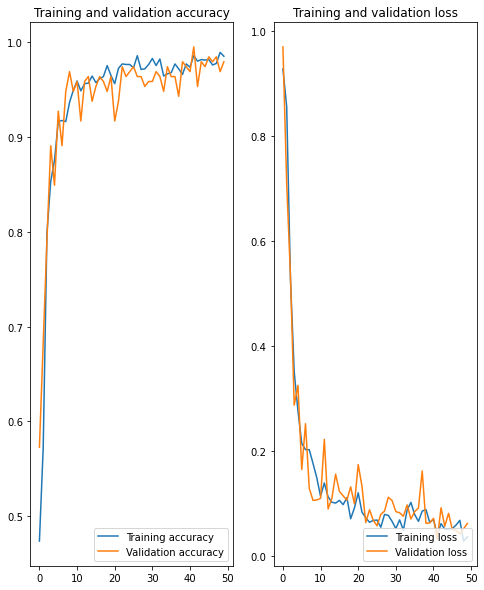

In [43]:
plt.figure(figsize=(8,10))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and validation accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training loss')
plt.plot(range(EPOCHS), val_loss, label='Validation loss')
plt.legend(loc='lower right')
plt.title('Training and validation loss')

In [54]:
import numpy as np
np.argmax([5.2529875e-10, 1.0000000e+00, 1.0181123e-11])

1

1/1 [==============================] - 0s 316ms/step


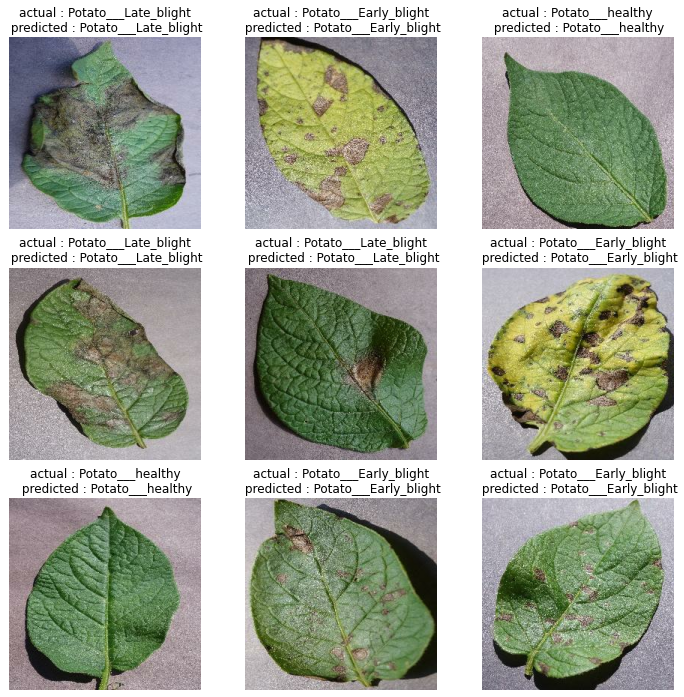

In [68]:

plt.figure(figsize=(12,12))
for image_batch, image_label in test_ds.take(1):
    batch_prediction = model.predict(image_batch)
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(f"actual : {class_names[image_label[i].numpy()]}\n predicted : {class_names[np.argmax(batch_prediction[i])]}")
        plt.axis('off')

In [71]:
import os
os.listdir("../models/")

['1']

In [70]:
model_version = 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
